In [1]:
from __future__ import division
from sys import exit
from math import sqrt
from numpy import array
from scipy.optimize import fmin_l_bfgs_b
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

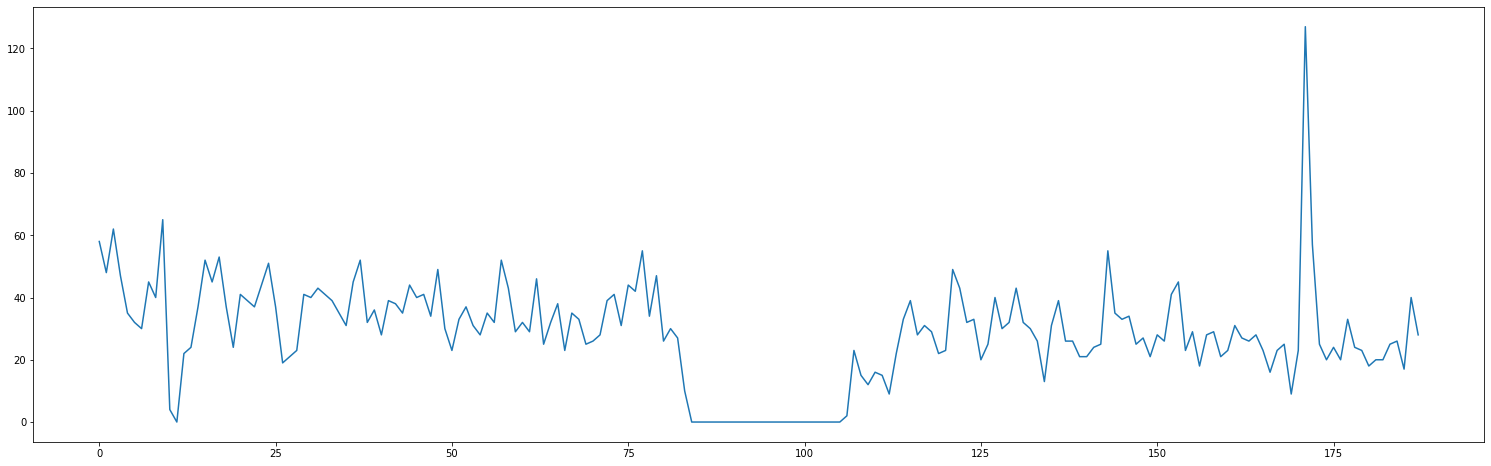

In [2]:
path = r'C:\Users\h\Desktop\工作簿1.xlsx'
df = pd.read_excel(path)
data = []
for i in df['销量']:
    data.append(i)
plt.figure(figsize=(26,8))
plt.plot(data)
plt.savefig(r'C:\Users\h\Desktop\1.png')

RMSE的实现

In [3]:
# Y：   实际值
# a：   平滑值
# b:    趋势性
# s:    季节性趋势
# m:    预测时间

def RMSE(params, *args):#位置参数

    Y = args[0]
    type = args[1]
    rmse = 0

    if type == 'linear':
        #线性回归，两参
        #初始值
        alpha, beta = params
        a = [Y[0]]
        b = [Y[1] - Y[0]]
        y = [a[0] + b[0]]

        for i in range(len(Y)):

            a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
            b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
            y.append(a[i + 1] + b[i + 1])

    else:
        #三参
        alpha, beta, gamma = params
        m = args[2]     
        a = [sum(Y[0:m]) / float(m)]
        b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]

        if type == 'additive':
            #累加性
            s = [Y[i] - a[0] for i in range(m)]
            y = [a[0] + b[0] + s[0]]

            for i in range(len(Y)):

                a.append(alpha * (Y[i] - s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] - a[i] - b[i]) + (1 - gamma) * s[i])
                y.append(a[i + 1] + b[i + 1] + s[i + 1])

        elif type == 'multiplicative':
            #累乘性
            s = [Y[i] / a[0] for i in range(m)]
            y = [(a[0] + b[0]) * s[0]]

            for i in range(len(Y)):

                a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
                y.append((a[i + 1] + b[i + 1]) * s[i + 1])

        else:

            exit('Type must be either linear, additive or multiplicative')

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y, y[:-1])]) / len(Y))

    return rmse

线性实现

In [4]:
def linear(x, fc, alpha = None, beta = None):

    Y = x[:]

    if (alpha == None or beta == None):

        initial_values = array([0.3, 0.1])
        boundaries = [(0, 1), (0, 1)]
        type = 'linear'

        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type), bounds = boundaries, approx_grad = True)
        alpha, beta = parameters[0]

    a = [Y[0]]
    b = [Y[1] - Y[0]]
    y = [a[0] + b[0]]
    rmse = 0

    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append(a[-1] + b[-1])

        a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        y.append(a[i + 1] + b[i + 1])

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, rmse


累加性

In [5]:
def additive(x, m, fc, alpha = None, beta = None, gamma = None):

    Y = x[:]

    if (alpha == None or beta == None or gamma == None):

        initial_values = array([0.3, 0.1, 0.1])
        boundaries = [(0, 1), (0, 1), (0, 1)]
        type = 'additive'

        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type, m), bounds = boundaries, approx_grad = True)
        alpha, beta, gamma = parameters[0]

    a = [sum(Y[0:m]) / float(m)]
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
    s = [Y[i] - a[0] for i in range(m)]
    y = [a[0] + b[0] + s[0]]
    rmse = 0

    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append(a[-1] + b[-1] + s[-m])

        a.append(alpha * (Y[i] - s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] - a[i] - b[i]) + (1 - gamma) * s[i])
        y.append(a[i + 1] + b[i + 1] + s[i + 1])
    #最小二乘法计算误差（L-BFGS)
    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, gamma, rmse

累乘性

In [6]:
# RMSE : callable f(x,*args)   最小化的目标，一般是loss函数
# x0 : ndarray                 最初的猜测，即待更新参数初始值。
# fprime :                     梯度函数，本函数未设
# args :                       上RMSE函数的参数
# bounds : list                (min, max) pairs for each element in x, defining the bounds on that parameter. 
# approx_grad                  返回数字近似梯度

def multiplicative(x, m, fc, alpha = None, beta = None, gamma = None):

    Y = x[:]

    if (alpha == None or beta == None or gamma == None):

        initial_values = array([0.0, 1.0, 0.0])
        boundaries = [(0, 1), (0, 1), (0, 1)]
        type = 'multiplicative'

        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type, m), bounds = boundaries, approx_grad = True)
        alpha, beta, gamma = parameters[0]
    # 初始值 a表示baseline， b表示趋势，s表示季节性，y表示预测值，m表示周期，分别取第一个周期的统计数据为初始值 
    a = [sum(Y[0:m]) / float(m)]
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
    s = [Y[i] / a[0] for i in range(m)]
    y = [(a[0] + b[0]) * s[0]]
    rmse = 0
    # 套用上面公式，从0开始，fc表示预测的数量，如已知前7天，预测接下来的一个小时的数据，如果数据粒度是5分钟，fc为12。
    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append((a[-1] + b[-1]) * s[-m])
        # 预测值为
        a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
        y.append((a[i + 1] + b[i + 1]) * s[i + 1])
    # 计算rmse值 
    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, gamma, rmse


In [13]:
def plot_mul(x, m, fc): 
    mul = data[-1:] + multiplicative(x, m, fc)[0]
    mul = pd.DataFrame(mul, columns=['预测值'])
    mul.index = mul.index + len(data)-1
    data1 = pd.DataFrame(data, columns=['实际值'])
    plt.figure(figsize=(26,8))
    plt.plot(data1.index, data1['实际值'], label = '实际值')
    plt.plot(mul.index, mul['预测值'], label = '预测值')
    plt.legend(loc='best')
    plt.title("Sales Forecast")
    plt.show()

 

In [8]:
def plot_add(x, m, fc):
    add = data[-1:] + additive(x, m, fc)[0]
    add = pd.DataFrame(add, columns=['预测值'])
    add.index = add.index + len(data)-1
    data1 = pd.DataFrame(data, columns=['实际值'])
    plt.figure(figsize=(26,8))
    plt.plot(data1.index, data1['实际值'], label = '实际值')
    plt.plot(add.index, add['预测值'], label = '预测值')
    plt.legend(loc='best')
    plt.title("Sales Forecast")
    plt.show()

In [15]:
plot_mul(data,12, 10)

ZeroDivisionError: float division by zero

In [ ]:
plot_add(data, 100, 100)

In [ ]:
multiplicative(data, 10, 10)

In [ ]:
additive(data, 10, 10)